In [1]:
import pandas as pd
import matplotlib.dates as mdates

In [2]:
# read data
data = pd.read_csv(r"../Data/Aggregated_Final_Lin_Rakeen_Fixed_returns.csv")

In [3]:
# copy without warnings
pd.options.mode.chained_assignment = None

In [4]:
# # make sweetviz report
# import sweetviz as sv

# report = sv.analyze(data)

# # save report
# report.show_html("../EDA/fixed_return_report.html")

In [5]:
# drop magnitude and Direction columns
data = data.drop(columns=["magnitude", "Direction"])
data.head(15)

,date_dt,positive_count_bitcoin,negative_count_bitcoin,neutral_count_bitcoin,positive_avg_score_bitcoin,negative_avg_score_bitcoin,neutral_avg_score_bitcoin,total_news_count_bitcoin,total_news_score_bitcoin,signal_bitcoin,...,T5YIE_lag1,T5YIE_lag2,S&P500_Close_lag1,S&P500_Close_lag2,VIX_Close_lag1,VIX_Close_lag2,S&P_Return_lag1,S&P_Return_lag2,gg_trend,Daily Return
0,2021-04-22,1.0,1.0,5.0,0.642198,0.476258,0.731610,7.0,0.165941,0.000000,...,2.52,2.56,4134.939941,4163.259766,18.680000,17.290001,-0.006802,-0.005307,0.137663,-0.040582
1,2021-04-23,1.0,1.0,5.0,0.642198,0.476258,0.731610,7.0,0.165941,0.000000,...,2.53,2.52,4173.419922,4134.939941,17.500000,18.680000,0.009306,-0.006802,0.137663,-0.013001
2,2021-04-24,1.0,11.0,3.0,0.586267,0.906848,0.899653,15.0,-9.389061,-0.833333,...,2.42,2.53,4134.979980,4173.419922,18.709999,17.500000,-0.009211,0.009306,0.137663,-0.020620
3,2021-04-25,1.0,11.0,3.0,0.586267,0.906848,0.899653,15.0,-9.389061,-0.833333,...,2.44,2.42,4180.169922,4134.979980,17.330000,18.709999,0.010929,-0.009211,0.018928,-0.021133
4,2021-04-26,1.0,11.0,3.0,0.586267,0.906848,0.899653,15.0,-9.389061,-0.833333,...,2.44,2.44,4180.169922,4180.169922,17.330000,17.330000,0.000000,0.010929,0.018928,0.097480
5,2021-04-27,4.0,0.0,4.0,0.667552,0.000000,0.856313,8.0,2.670206,1.000000,...,2.44,2.44,4180.169922,4180.169922,17.330000,17.330000,0.000000,0.000000,0.018928,0.018548
6,2021-04-28,4.0,0.0,4.0,0.667552,0.000000,0.856313,8.0,2.670206,1.000000,...,2.47,2.44,4187.620117,4180.169922,17.639999,17.330000,0.001782,0.000000,0.018928,-0.003794
7,2021-04-29,4.0,0.0,4.0,0.667552,0.000000,0.856313,8.0,2.670206,1.000000,...,2.51,2.47,4186.720215,4187.620117,17.559999,17.639999,-0.000215,0.001782,0.018928,-0.023430
8,2021-04-30,3.0,1.0,4.0,0.758420,0.778473,0.956340,8.0,1.496786,0.500000,...,2.54,2.51,4183.180176,4186.720215,17.280001,17.559999,-0.000846,-0.000215,0.018928,0.075415
9,2021-05-01,3.0,1.0,4.0,0.758420,0.778473,0.956340,8.0,1.496786,0.500000,...,2.56,2.54,4211.470215,4183.180176,17.610001,17.280001,0.006763,-0.000846,0.018928,0.001348


**Linear Regression Implementation**

In [6]:
# linear regression model
from sklearn.linear_model import LinearRegression


data.set_index("date_dt", inplace=True)
data.index = pd.to_datetime(data.index)

# convert return to moving average
data["Daily_Return_rolling_15_avg"] = data["Daily Return"].rolling(window=15).mean()
data.dropna(inplace=True)
data.head(20)

,positive_count_bitcoin,negative_count_bitcoin,neutral_count_bitcoin,positive_avg_score_bitcoin,negative_avg_score_bitcoin,neutral_avg_score_bitcoin,total_news_count_bitcoin,total_news_score_bitcoin,signal_bitcoin,TWITTER_SENTIMENT_DAILY_AVG,...,T5YIE_lag2,S&P500_Close_lag1,S&P500_Close_lag2,VIX_Close_lag1,VIX_Close_lag2,S&P_Return_lag1,S&P_Return_lag2,gg_trend,Daily Return,Daily_Return_rolling_15_avg
date_dt,,,,,,,,,,,,,,,,,,,,,
2021-05-06,0.0,1.0,2.0,0.000000,0.827074,0.900657,3.0,-0.827074,-1.000000,-0.0058,...,2.60,4164.660156,4192.660156,19.480000,18.309999,-0.006678,0.002748,0.122346,-0.018055,0.003011
2021-05-07,0.0,1.0,2.0,0.000000,0.827074,0.900657,3.0,-0.827074,-1.000000,-0.0075,...,2.62,4167.589844,4164.660156,19.150000,19.480000,0.000703,-0.006678,0.122346,0.016877,0.006842
2021-05-08,0.0,1.0,2.0,0.000000,0.827074,0.900657,3.0,-0.827074,-1.000000,-0.0228,...,2.68,4201.620117,4167.589844,18.389999,19.150000,0.008165,0.000703,0.122346,0.024922,0.009370
2021-05-09,0.0,1.0,2.0,0.000000,0.827074,0.900657,3.0,-0.827074,-1.000000,-0.0228,...,2.66,4232.600098,4201.620117,16.690001,18.389999,0.007373,0.008165,0.105151,-0.009766,0.010093
2021-05-10,2.0,1.0,0.0,0.869209,0.913061,0.000000,3.0,0.825356,0.333333,-0.0228,...,2.65,4232.600098,4232.600098,16.690001,16.690001,0.000000,0.007373,0.105151,-0.041596,0.008729
2021-05-11,2.0,1.0,0.0,0.869209,0.913061,0.000000,3.0,0.825356,0.333333,0.0048,...,2.65,4232.600098,4232.600098,16.690001,16.690001,0.000000,0.000000,0.105151,0.015010,0.003231
2021-05-12,2.0,0.0,0.0,0.949838,0.000000,0.000000,2.0,1.899676,1.000000,0.0153,...,2.65,4188.430176,4232.600098,19.660000,16.690001,-0.010436,0.000000,0.105151,-0.142967,-0.007536
2021-05-13,2.0,0.0,0.0,0.949838,0.000000,0.000000,2.0,1.899676,1.000000,0.0130,...,2.71,4152.100098,4188.430176,21.840000,19.660000,-0.008674,-0.010436,0.105151,0.011443,-0.006521
2021-05-14,1.0,8.0,2.0,0.906305,0.798987,0.774572,11.0,-5.485593,-0.777778,-0.0168,...,2.68,4063.040039,4152.100098,27.590000,21.840000,-0.021449,-0.008674,0.105151,0.003300,-0.004739


In [7]:
from sklearn.metrics import mean_squared_error
import joblib


# cumulative sum for last 100 days of news sentiment
data["total_news_score_lag_100_sum_bit"] = (
    data["total_news_score_bitcoin"].rolling(100).sum()
)
data["total_news_score_lag_100_sum_coin"] = (
    data["total_news_score_coinbase"].rolling(100).sum()
)
data = data.dropna()

# Featues chosen based on pearson correlation
cols = [
    "stoch_%K",
    "stoch_%D",
    "S&P500 Return",
    "rsi",
    "negative_count_bitcoin",
    "positive_count_bitcoin",
    "total_news_score_bitcoin",
    "negative_avg_score_bitcoin",
    "positive_avg_score_bitcoin",
    "signal_bitcoin",
    "gg_trend",
    "total_news_score_lag_100_sum_coin",
    "total_news_score_lag_100_sum_bit",
    "Daily_Return_rolling_15_avg",
]
X = data[cols].drop(columns=["Daily_Return_rolling_15_avg"])
y = data["Daily_Return_rolling_15_avg"]

split_date = "2023-03-01"
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

r_squared = model.score(X_test, y_test)
print(f"R Squared: {r_squared}")

# print adjusted r squared
n = X_test.shape[0]
p = X_test.shape[1]
adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
print(f"Adjusted R Squared: {adj_r_squared}")

# save model
joblib.dump(model, "../Modeling/models/LR_model_ideal.pkl")

Mean Squared Error: 1.8128805438110775e-05
R Squared: 0.5703388500451284
Adjusted R Squared: 0.5552833380521005


['../Modeling/models/LR_model_ideal.pkl']

**Calculating Results**

In [8]:
# make a dataframe with y_test and y_pred
results = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})

# compute residuals
results["residuals"] = results["y_test"] - results["y_pred"]

# save results
# results.to_csv("../Modeling/models/LR_results_ideal.csv")

daily_test_returns = data[data.index >= split_date]["Daily Return"]
daily_close = data[data.index >= split_date]["Close"].shift(-1)

**PLotting Results**

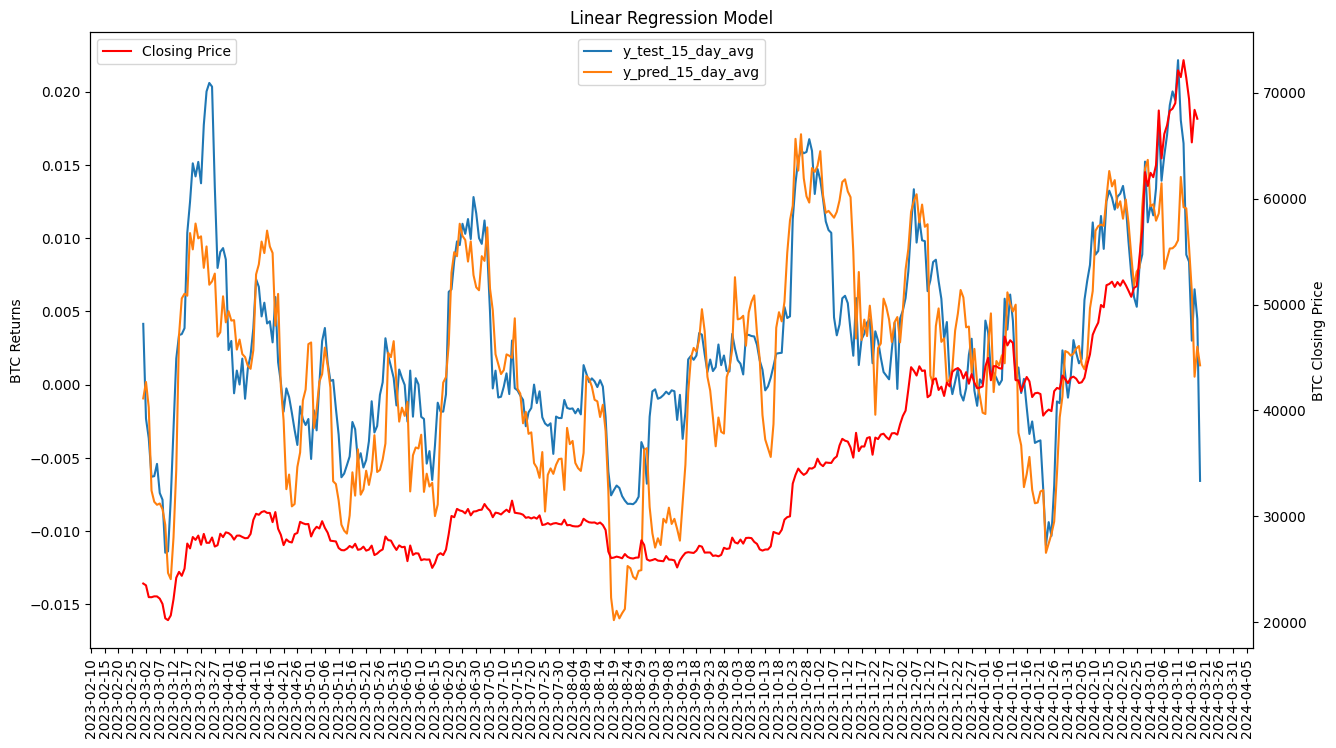

In [9]:
# plot results
import matplotlib.pyplot as plt

plt.plot(results["y_test"], label="y_test_15_day_avg")
plt.plot(results["y_pred"], label="y_pred_15_day_avg")
plt.legend(loc="upper center")
plt.title("Linear Regression Model")
plt.xticks(rotation=90)
plt.gcf().set_size_inches(15, 8)
# Set x-axis major ticks to occur every 300 days.
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.ylabel("BTC Returns")

# plot the close price on the same graph on the right axis
plt.twinx()
plt.plot(daily_close, color="red", label="Closing Price")
plt.legend(loc="upper left")
plt.ylabel("BTC Closing Price")

plt.xticks(rotation=90)
plt.gcf().set_size_inches(15, 8)
# Set x-axis major ticks to occur every 300 days.
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))


plt.show()

> According to the following results, the baseline model beats the ransom model.

In [15]:
# see if direction was right
results["direction"] = daily_test_returns * results["y_pred"]
results["direction"] = results["direction"].apply(lambda x: 1 if x > 0 else 0)

# print accuracy
accuracy = results["direction"].sum() / results["direction"].count()
print(f"Linear Regression Daily Direction Accuracy: {accuracy}")

results["actual_direction"] = daily_test_returns.apply(lambda x: 1 if x > 0 else 0)

# print confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(results["direction"], results["actual_direction"])
print(confusion_matrix)

# write out true positive, false positive, true negative, false negative
tp = confusion_matrix[0][0]
fp = confusion_matrix[0][1]
fn = confusion_matrix[1][0]
tn = confusion_matrix[1][1]

print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Negatives: {tn}")

# calculate precision
precision = tp / (tp + fp)
print(f"Precision: {precision}")

# calculate recall
recall = tp / (tp + fn)
print(f"Recall: {recall}")

# calculate f1 score
f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1}")

# make a column that picks direction randomly
import random

accuracies = []

for _ in range(90000):
    results["random_direction"] = results["y_pred"].apply(
        lambda x: random.choice([-1, 1])
    )
    results["random_direction"] = results["random_direction"] * daily_test_returns
    results["random_direction"] = results["random_direction"].apply(
        lambda x: 1 if x > 0 else 0
    )

    # calculate accuracy
    accuracy = results["random_direction"].sum() / results["random_direction"].count()
    accuracies.append(accuracy)

# print mean accuracy
print(f"Mean Random Daily Direction Accuracy: {sum(accuracies) / len(accuracies)}")

Linear Regression Daily Direction Accuracy: 0.5038961038961038
[[118  73]
 [ 71 123]]
True Positives: 118
False Positives: 73
False Negatives: 71
True Negatives: 123
Precision: 0.6178010471204188
Recall: 0.6243386243386243
F1 Score: 0.6210526315789474
Mean Random Daily Direction Accuracy: 0.49999497835497475


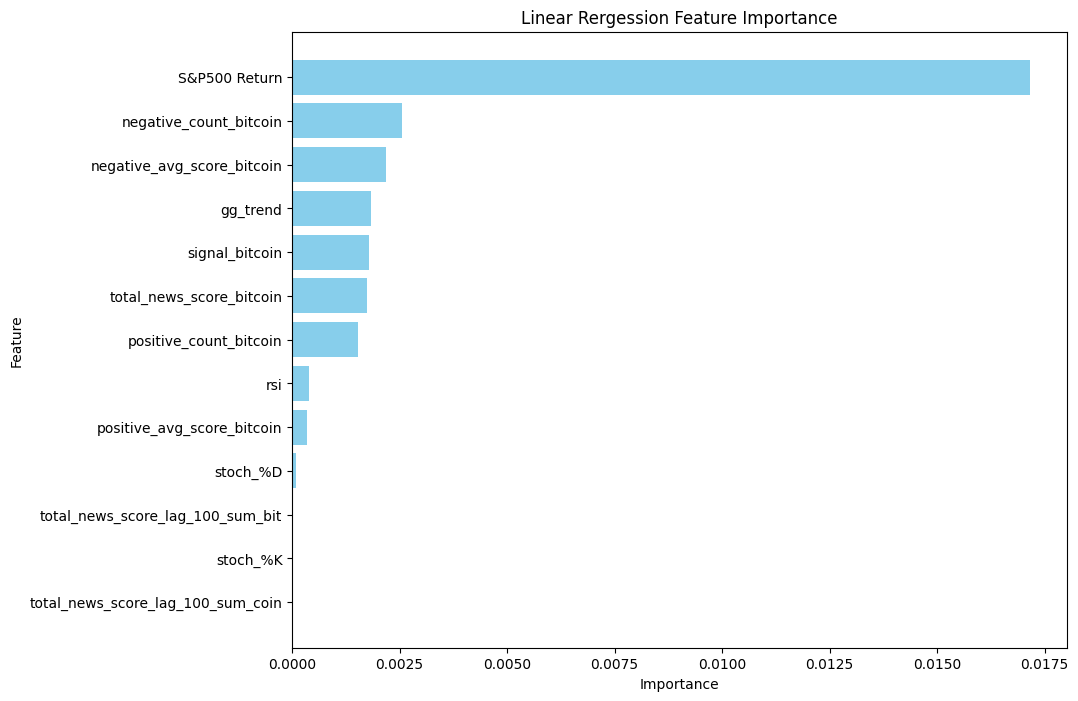

In [12]:
import matplotlib.pyplot as plt

# Feature importance
importance = model.coef_
feature_importance = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": importance}
)

# Sort by absolute value of importance
feature_importance["Importance"] = feature_importance["Importance"].abs()
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(
    feature_importance["Feature"], feature_importance["Importance"], color="skyblue"
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Linear Rergession Feature Importance")
plt.gca().invert_yaxis()  # Invert y axis to have the most important feature at top
plt.show()

**Random Forest Implementatin**

Mean Squared Error: 1.4388072495123205e-05
R Squared: 0.6589959666678993


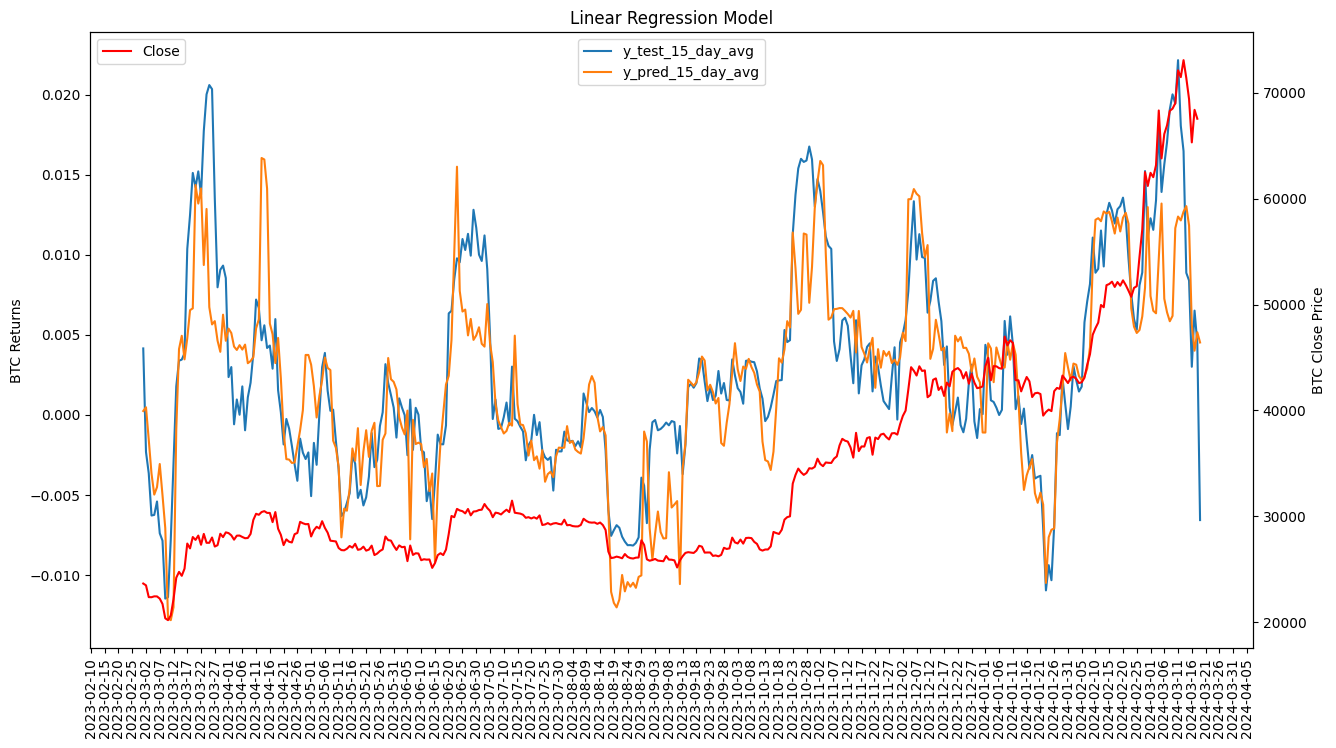

Feature ranking:
1. stoch_%D (0.42647534056430925)
2. rsi (0.2914302000961053)
3. stoch_%K (0.0348602940340487)
4. S&P500_Close_lag1 (0.023061062154759105)
5. S&P500 Close (0.017263336696546012)
6. total_news_score_lag_100_sum_bit (0.012327714851759243)
7. macd (0.012220358140034594)
8. S&P500_Close_lag2 (0.0086011106337535)
9. total_news_score_lag_100_sum_coin (0.008126479562329732)
10. 30D_Moving_STD (0.00716569338738793)
11. neutral_avg_score_coinbase (0.006364613870660872)
12. gg_trend (0.005819232738207019)
13. TWITTER_SENTIMENT_DAILY_AVG (0.005706264068360025)
14. VIX Close (0.005510908425642859)
15. macd_signal (0.005219546807756663)
16. T5YIE (0.0050246696161917025)
17. TWITTER_PUBLICATION_COUNT (0.0049351502376333125)
18. Lower Band (0.00485714320612914)
19. VIX_Close_lag2 (0.004793051200269112)
20. DGS10 (0.0044897829701346465)
21. total_news_score_coinbase (0.004418985174612115)
22. total_news_count_coinbase (0.0042284981195569215)
23. NEWS_SENTIMENT_DAILY_AVG (0.00418059484

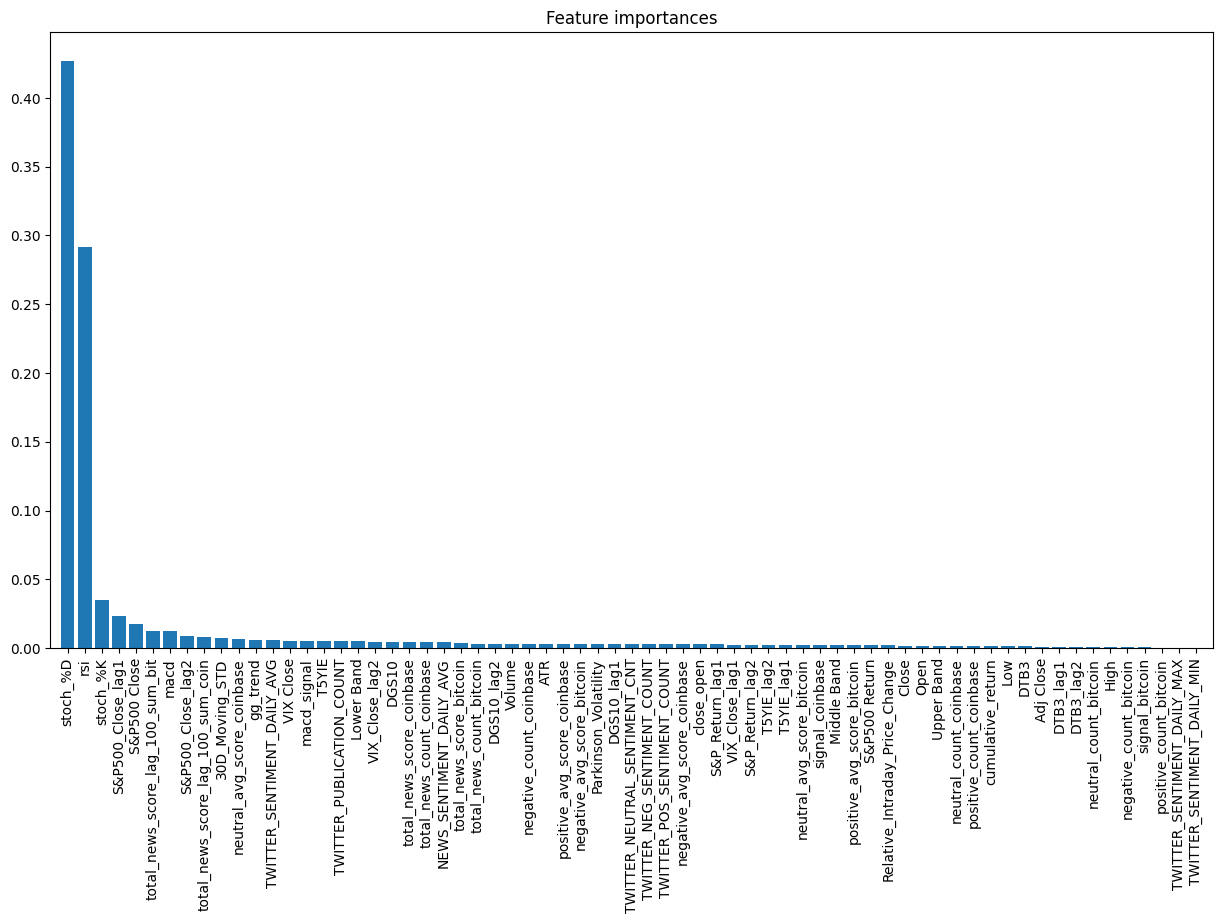

Random Forest Daily Direction Accuracy: 0.5038961038961038


In [13]:
# random forest model
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# fit model
model = RandomForestRegressor()

data = data.dropna(subset=["Daily_Return_rolling_15_avg"])

X = data.drop(
    columns=[
        "Daily_Return_rolling_15_avg",
        "Daily Return",
    ]
)
y = data["Daily_Return_rolling_15_avg"]


split_date = "2023-03-01"
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

r_squared = model.score(X_test, y_test)
print(f"R Squared: {r_squared}")


# save model
joblib.dump(model, "../Modeling/models/ideal_RF/model_random_forest.pkl")

# make a dataframe with y_test and y_pred
results = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})

# compute residuals
results["residuals"] = results["y_test"] - results["y_pred"]

# save results
results.to_csv("../Modeling/models/ideal_RF/results_random_forest.csv")

plt.plot(results["y_test"], label="y_test_15_day_avg")
plt.plot(results["y_pred"], label="y_pred_15_day_avg")
plt.legend(loc="upper center")
plt.title("Linear Regression Model")
plt.xticks(rotation=90)
plt.gcf().set_size_inches(15, 8)
# Set x-axis major ticks to occur every 300 days.
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.ylabel("BTC Returns")

# plot the close price on the same graph on the right axis
plt.twinx()
plt.plot(daily_close, color="red", label="Close")
plt.legend(loc="upper left")
plt.ylabel("BTC Close Price")

plt.xticks(rotation=90)
plt.gcf().set_size_inches(15, 8)
# Set x-axis major ticks to occur every 300 days.
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

plt.show()

# feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {X.columns[indices[f]]} ({importances[indices[f]]})")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(X.columns)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.gcf().set_size_inches(15, 8)
plt.show()

# see if direction was right
results["direction"] = daily_test_returns * results["y_pred"]
results["direction"] = results["direction"].apply(lambda x: 1 if x > 0 else 0)

# print accuracy
accuracy = results["direction"].sum() / results["direction"].count()
print(f"Random Forest Daily Direction Accuracy: {accuracy}")